## Read data

In [83]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, average_precision_score, precision_recall_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
data_path = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2_cv'

In [3]:
fold_dfs = [pd.read_csv(os.path.join(data_path, 'infer', 'f' + str(idx) + '.csv'), header=None) for idx in range(1, 6)]

In [4]:
fold_dfs = [pd.DataFrame(normalize(fold_df.iloc[:,0:51], norm='l1', axis=1)) for fold_df in fold_dfs]

In [102]:
gs_mixtures = pd.concat(fold_dfs, ignore_index=True)
gs_mixtures.columns = [str(idx) for idx in range(50)]

In [6]:
fold_dfs[0].head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000102,0.000710,0.005845,0.000760,0.005574,0.023033,0.002161,0.010837,0.028338,0.099127,...,0.010616,0.000695,0.034566,0.016902,0.006617,0.007723,0.000816,0.091156,0.000708,0.005645
1,0.001703,0.000916,0.000171,0.001579,0.000460,0.000491,0.000152,0.001079,0.000461,0.000586,...,0.000279,0.044830,0.000267,0.001114,0.000692,0.001185,0.000411,0.000647,0.005836,0.000492
2,0.000225,0.014341,0.020419,0.002033,0.006820,0.009159,0.000238,0.161934,0.030551,0.019383,...,0.004070,0.000186,0.004685,0.029209,0.001002,0.018981,0.000246,0.005228,0.000678,0.021791
3,0.027494,0.000727,0.007390,0.000590,0.012896,0.000679,0.001078,0.002600,0.002665,0.002715,...,0.151078,0.000464,0.002285,0.135078,0.046876,0.000712,0.000072,0.006665,0.020374,0.121664
4,0.010215,0.050714,0.004430,0.004983,0.001867,0.001266,0.007602,0.001070,0.012861,0.005619,...,0.000331,0.002321,0.003944,0.000475,0.008236,0.097787,0.039732,0.002001,0.002745,0.003233


## Death

In [7]:
data_path = r'/home/mcb/users/pnair6/mimic/data/data_files_14Nov'

In [8]:
fold_note_dfs = [pd.read_csv(os.path.join(data_path, 'fold' + str(idx), 'train.csv')) for idx in range(1, 6)]

In [27]:
death_dfs = [fold_note_df[['HADM_ID', 'DEATH']].drop_duplicates().reset_index(drop=True) for fold_note_df in fold_note_dfs]
deaths = [death_df['DEATH'] for death_df in death_dfs]

In [22]:
fold_note_df = pd.concat(fold_note_dfs, ignore_index=True)

In [10]:
fold_note_df.head()

,Unnamed: 0,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,0,132663.0,2138-09-12 16:09:00,chief complaint: respiratory failure i saw and...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,992
1,1,132663.0,2138-09-12 16:13:00,chief complaint: respiratory distress hpi: yea...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,1520
2,2,132663.0,2138-09-13 04:53:00,demographics day of intubation: day of mechani...,Respiratory,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,231
3,3,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,164
4,4,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,279


In [11]:
death_df = fold_note_df[['HADM_ID', 'DEATH']].drop_duplicates().reset_index(drop=True)
death = death_df['DEATH'].astype(int)

In [12]:
death_df

,HADM_ID,DEATH
0,132663.0,0
1,178961.0,0
2,170269.0,0
3,148625.0,0
4,135916.0,0
...,...,...
1386,115993.0,1
1387,182849.0,1
1388,130887.0,0
1389,194269.0,0


## CV

### LR

In [63]:
auprc = []
acc = []
for idx in range(5):
    cv_test_mixture = fold_dfs[idx].copy()
    test_death = deaths[idx].copy()
    train_fold_dfs = fold_dfs.copy()
    del train_fold_dfs[idx]
    cv_train_mixtures = pd.concat(train_fold_dfs)
    train_deaths = deaths.copy()
    del train_deaths[idx]
    train_deaths = pd.concat(train_deaths)

    lr = LogisticRegression(class_weight='balanced', solver='lbfgs', C=1.77)
    
    lr.fit(cv_train_mixtures, train_deaths)
    test_predictions_lr = lr.predict(cv_test_mixture)
    auprc.append(average_precision_score(test_death, test_predictions_lr))
    acc.append(accuracy_score( test_death, test_predictions_lr))
    print('auprc:', auprc[-1])
    print('acc:', acc[-1])
    
print('mean auprc:', np.mean(auprc))
print('mean acc:', np.mean(acc))

auprc: 0.18427283489663965
acc: 0.7482014388489209
auprc: 0.23276821580710116
acc: 0.7517985611510791
auprc: 0.2897249767753365
acc: 0.7913669064748201
auprc: 0.20413044082108828
acc: 0.7517985611510791
auprc: 0.27023471308183794
acc: 0.7383512544802867
mean auprc: 0.23622623627640066
mean acc: 0.7563033444212371


#### grid search

In [39]:
lr_estimator = LogisticRegression(class_weight='balanced')

In [78]:
lr_hyperparams = {
    'C': np.arange(1.0, 2.0, step=0.01),
    'max_iter': [100, 200, 300],
    'solver': ['liblinear', 'lbfgs'],
              }

In [79]:
lr_searcher = GridSearchCV(estimator=lr_estimator, n_jobs=12, param_grid=lr_hyperparams, scoring='average_precision', cv=5, verbose=1)

In [80]:
lr_searcher.fit(gs_mixtures, death)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 774 tasks      | elapsed:   11.4s
[Parallel(n_jobs=12)]: Done 1524 tasks      | elapsed:   22.4s
[Parallel(n_jobs=12)]: Done 2574 tasks      | elapsed:   37.2s
[Parallel(n_jobs=12)]: Done 3000 out of 3000 | elapsed:   43.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': array([1.  , 1....
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98

In [81]:
lr_searcher.best_params_

{'C': 1.9800000000000009, 'max_iter': 100, 'solver': 'liblinear'}

In [82]:
lr_searcher.best_score_

0.4065369226363649

In [84]:
coefs = lr_searcher.best_estimator_.coef_[0]

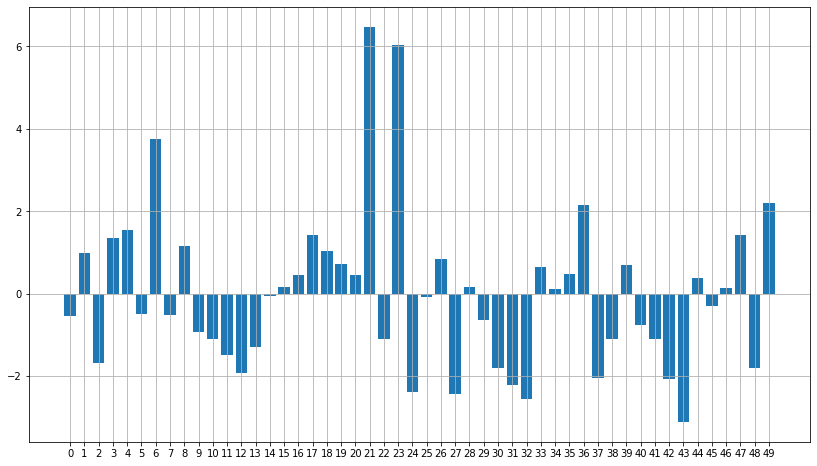

In [85]:
plt.figure(figsize=(14, 8))
plt.bar(range(coefs.shape[0]), coefs)
plt.xticks(range(len(coefs)), range(len(coefs)))
plt.grid()

## Top patients
Most correlated topics are 21 and 23 (the same as the ones found by Pearson correlation and cosine similarity)

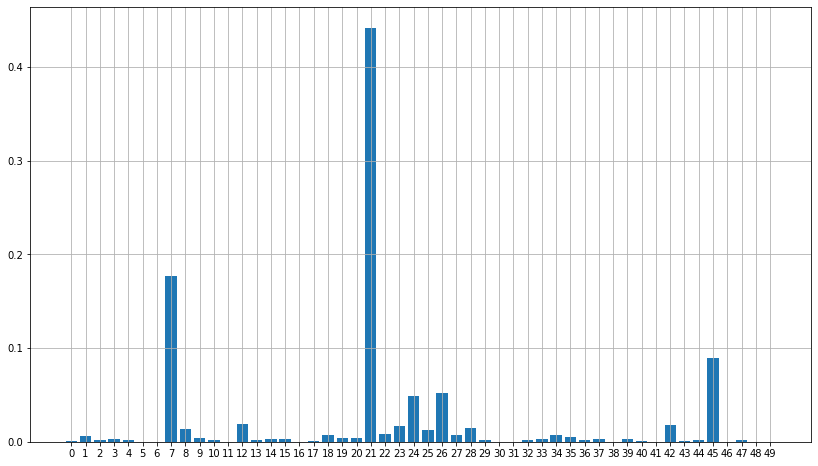

In [113]:
plt.figure(figsize=(14, 8))
plt.bar(range(50), gs_mixtures.iloc[273])
plt.xticks(range(50), range(50))
plt.grid()

In [95]:
death_df[death_df['DEATH'] == 1]

,HADM_ID,DEATH
14,159164.0,1
17,106586.0,1
55,133974.0,1
87,100292.0,1
92,171628.0,1
...,...,...
1354,135621.0,1
1375,119512.0,1
1377,113289.0,1
1386,115993.0,1


In [114]:
death_df.iloc[748]

HADM_ID    152136.0
DEATH           0.0
Name: 748, dtype: float64

In [115]:
fold_note_df[fold_note_df['HADM_ID'] == 152136.0]

,Unnamed: 0,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
18421,4621,152136.0,2145-10-04 03:24:00,the pt. is a y/o m with unknown pmh found down...,Nursing,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,230
18422,4622,152136.0,2145-10-04 03:24:00,.h/o cardiac arrest assessment: action: respon...,Nursing,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,32
18423,4623,152136.0,2145-10-04 11:59:00,chief complaint: hour events: a- line placed s...,Physician,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,571
18424,4624,152136.0,2145-10-04 17:35:00,airway airway placement data known difficult i...,Respiratory,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,91
18425,4625,152136.0,2145-10-04 03:24:00,the pt. is a y/o m with unknown pmh found down...,Nursing,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,514
18426,4626,152136.0,2145-10-05 02:32:00,the pt. is a y/o m with unknown pmh found down...,Nursing,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,543
18427,4627,152136.0,2145-10-05 05:23:00,demographics day of intubation: day of mechani...,Respiratory,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,155
18428,4628,152136.0,2145-10-05 05:44:00,chief complaint: hour events: -htn: sbp in > s...,Physician,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,410
18429,4629,152136.0,2145-10-05 05:44:00,chief complaint: hour events: -htn: sbp in > s...,Physician,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,666
18430,4630,152136.0,2145-10-05 02:32:00,the pt. is a y/o m with unknown pmh found down...,Nursing,279344,2145-10-03 19:35:00,2145-10-14 13:39:00,2145-10-03 21:00:00,2145-10-14 00:00:00,1,10.125,0,1,1,541


In [106]:
gs_mixtures.sort_values(by='21', ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
748,0.000460,0.017590,0.000387,0.000460,0.000074,0.006489,0.000504,0.073648,0.003194,0.000233,...,0.000221,0.001790,0.007556,0.000083,0.000172,0.006007,0.000091,0.001619,0.000355,0.008964
1120,0.000979,0.013111,0.002655,0.000221,0.005519,0.010457,0.003438,0.005407,0.205165,0.002008,...,0.029401,0.000210,0.046553,0.000153,0.008544,0.015348,0.017616,0.008802,0.001053,0.002331
273,0.000858,0.005965,0.001512,0.003298,0.002313,0.000315,0.000113,0.177154,0.013795,0.004569,...,0.000439,0.000064,0.018429,0.000838,0.002303,0.089713,0.000077,0.002231,0.000055,0.000067
1238,0.001374,0.016907,0.023209,0.023687,0.000773,0.000312,0.002281,0.012904,0.033034,0.011788,...,0.000129,0.000133,0.018816,0.012928,0.001059,0.021204,0.000375,0.000447,0.000531,0.016439
215,0.000933,0.036865,0.006524,0.008488,0.000269,0.009988,0.000447,0.002811,0.084123,0.010020,...,0.000489,0.000522,0.016273,0.022317,0.000285,0.011172,0.002797,0.000805,0.000442,0.022533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.117219,0.000151,0.000192,0.194705,0.000288,0.000323,0.000054,0.000580,0.004795,0.000458,...,0.000542,0.001326,0.000381,0.029316,0.000157,0.000432,0.000077,0.000107,0.000238,0.001293
456,0.001238,0.000094,0.009495,0.000754,0.013748,0.000412,0.002704,0.000417,0.010361,0.001424,...,0.430816,0.000373,0.004186,0.002123,0.020155,0.000579,0.001992,0.001003,0.004672,0.165202
599,0.001079,0.000894,0.000605,0.245853,0.002195,0.003984,0.079905,0.021917,0.001731,0.000643,...,0.001494,0.007269,0.000681,0.001963,0.012520,0.007466,0.000235,0.016375,0.036614,0.000497
361,0.003948,0.003255,0.000699,0.001992,0.002716,0.007501,0.000228,0.000186,0.000272,0.000581,...,0.013682,0.005341,0.000481,0.424091,0.001912,0.011105,0.000398,0.000133,0.014614,0.002030
